In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
# PCA module
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import r2_score
import datetime

In [2]:
r_dir = r'../raw_data/'
c_dir = r'../cleaned_data/'

In [3]:
yellow_12_2018 = pd.read_csv(r_dir+'yellow_tripdata_2018-12.csv')
taxi_zone = pd.read_csv(r_dir+'taxi_zones.csv')

In [4]:
# convert to datetime object
yellow_12_2018['tpep_pickup_datetime'] = pd.to_datetime(yellow_12_2018['tpep_pickup_datetime'],format ='%Y-%m-%d %H:%M:%S.%f')
yellow_12_2018['tpep_dropoff_datetime'] = pd.to_datetime(yellow_12_2018['tpep_dropoff_datetime'],format ='%Y-%m-%d %H:%M:%S.%f')

In [7]:
# create time features
yellow_12_2018['DOW'] = yellow_12_2018['tpep_pickup_datetime'].dt.weekday
yellow_12_2018['Hour_of_Day'] = yellow_12_2018['tpep_pickup_datetime'].dt.hour
yellow_12_2018['DOM'] = yellow_12_2018['tpep_pickup_datetime'].dt.day
yellow_12_2018.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,DOW,Hour_of_Day,DOM
0,1,2018-12-01 00:28:22,2018-12-01 00:44:07,2,2.5,1,N,148,234,1,12.0,0.5,0.5,3.95,0.0,0.3,17.25,5,0,1
1,1,2018-12-01 00:52:29,2018-12-01 01:11:37,3,2.3,1,N,170,144,1,13.0,0.5,0.5,2.85,0.0,0.3,17.15,5,0,1
2,2,2018-12-01 00:12:52,2018-12-01 00:36:23,1,0.0,1,N,113,193,2,2.5,0.5,0.5,0.00,0.0,0.3,3.80,5,0,1
3,1,2018-12-01 00:35:08,2018-12-01 00:43:11,1,3.9,1,N,95,92,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55,5,0,1
4,1,2018-12-01 00:21:54,2018-12-01 01:15:13,1,12.8,1,N,163,228,1,45.0,0.5,0.5,9.25,0.0,0.3,55.55,5,0,1


In [9]:
# Define essential columns
essential = ['tpep_pickup_datetime','tpep_dropoff_datetime','passenger_count','PULocationID','DOLocationID','DOW','Hour_of_Day','DOM']

In [8]:
# load taxi zone map
tzs=gpd.read_file(r_dir+'taxi_zones/taxi_zones.shp')

In [14]:
# Count and visualize the top 11 areas with most demand throughout December
yellow_12_2018 = yellow_12_2018[essential]
yellow_agg_12 = yellow_12_2018.groupby('PULocationID').count()
top11_12 = yellow_agg_12.nlargest(11,'DOLocationID')
tzs_yellow_12 = tzs.merge(top11_12, left_on = 'LocationID', right_on ='PULocationID' )

In [35]:
# Save the Processed Data
#yellow_12_2018.to_csv(c_dir+'yellow_12_2018.csv')

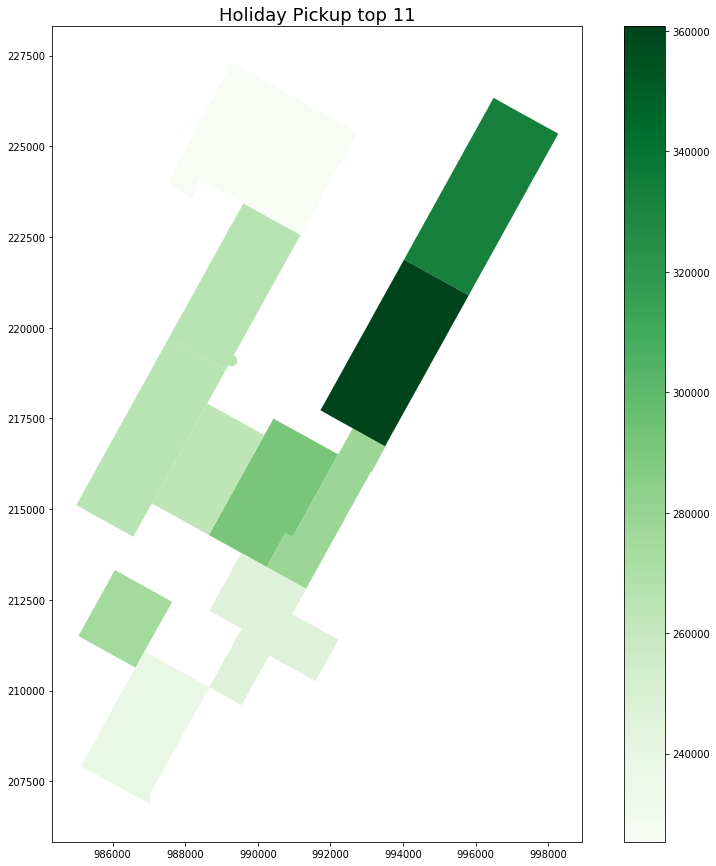

In [16]:
f,ax = plt.subplots(1, figsize=(15,10))
ax.set_title('December Pickup top 11 Locations', fontsize=18)
tzs_yellow_12.plot(axes=ax, column = 'DOLocationID', legend = True, cmap = "Greens")

In [19]:
# top 11 Pickup locations
tzs_yellow_12['zone']

0                     Clinton East
1              Lincoln Square East
2                   Midtown Center
3                     Midtown East
4                      Murray Hill
5     Penn Station/Madison Sq West
6        Times Sq/Theatre District
7                         Union Sq
8            Upper East Side North
9            Upper East Side South
10           Upper West Side South
Name: zone, dtype: object

In [36]:
# visualize daily pattern at time squares throughout the month
yellow_12_2018_c = pd.read_csv(c_dir+'yellow_12_2018.csv')

In [38]:
ind = yellow_12_2018_c['PULocationID'] == 230
timesquare_pu = yellow_12_2018_c[ind]

In [47]:
# agggregate by one hour interval,groupby DOW,DOM,Hour_of_Day
# mulitlevel representation useful for aggregating computation
timesquare_pu.groupby(['DOM','DOW','Hour_of_Day']).count().head(24)

Unnamed: 0  tpep_pickup_datetime  tpep_dropoff_datetime  \
DOM DOW Hour_of_Day                                                            
1   5   0                   613                   613                    613   
        1                   363                   363                    363   
        2                   250                   250                    250   
        3                   143                   143                    143   
        4                   117                   117                    117   
        5                    80                    80                     80   
        6                   102                   102                    102   
        7                   132                   132                    132   
        8                   286                   286                    286   
        9                   371                   371                    371   
        10                  503                   503                    503   
        11                  523                   523                    523   
        12                  540                   540                    540   
        13                  537                   537                    537   
        14                  498                   498                    498   
        15                  489                   489                    489   
        16                  487                   487                    487   
        17                  430                   430                    430   
        18                  439                   439                    439   
        19                  483                   483                    483   
        20                  501                   501                    501   
        21                  522                   522                    522   
        22                  547                   547                    547   
        23                  655                   655                    655   

                     passenger_count  PULocationID  DOLocationID  
DOM DOW Hour_of_Day                                               
1   5   0                        613           613           613  
        1                        363           363           363  
        2                        250           250           250  
        3                        143           143           143  
        4                        117           117           117  
        5                         80            80            80  
        6                        102           102           102  
        7                        132           132           132  
        8                        286           286           286  
        9                        371           371           371  
        10                       503           503           503  
        11                       523           523           523  
        12                       540           540           540  
        13                       537           537           537  
        14                       498           498           498  
        15                       489           489           489  
        16                       487           487           487  
        17                       430           430           430  
        18                       439           439           439  
        19                       483           483           483  
        20                       501           501           501  
        21                       522           522           522  
        22                       547           547           547  
        23                       655           655           655

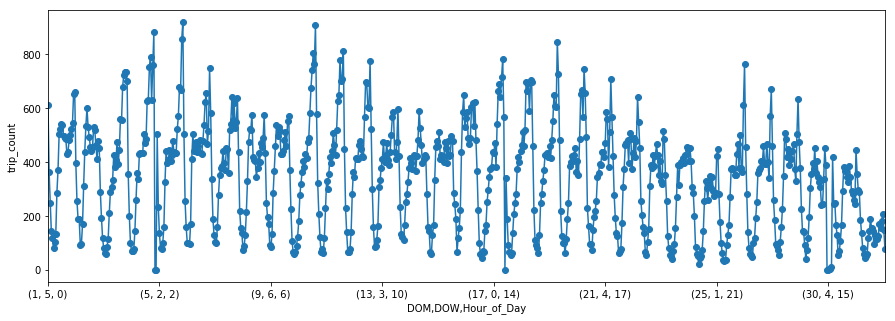

In [55]:
# pattern in whole month
hourly_count = timesquare_pu.groupby(['DOM','DOW','Hour_of_Day']).count()['passenger_count']
hourly_count.rename(columns={'passenger_count':'trip_count'},inplace=True)
ax = hourly_count.plot(x='DOM', y='trip_count', kind='line', style="-o", figsize=(15,5))
ax.set_ylabel("Hourly Pattern in a month")
ax.set_ylabel("trip_count")
plt.show()


In [70]:
# reset index  Training feature representaion
Timesquare_hourly_count = hourly_count.reset_index()
Timesquare_hourly_count.rename(columns={0:'trip_count'},inplace=True)
Timesquare_hourly_count.head()

,DOM,DOW,Hour_of_Day,trip_count
0,1,5,0,613
1,1,5,1,363
2,1,5,2,250
3,1,5,3,143
4,1,5,4,117


In [83]:
# December starts on Saturday
def dailyvisual(start,end):
    ind = (Timesquare_hourly_count['DOM'] >= start) &(Timesquare_hourly_count['DOM'] <= end)
    selected_days = Timesquare_hourly_count[ind]
    # Reindex for visualization
    selected_days = selected_days.set_index(['DOW','Hour_of_Day'])
    ax = selected_days.plot( y='trip_count', kind='line', style="-o", figsize=(15,5))
    ax.set_ylabel("trip_count")
    ax.set_title('hourly pattern by DOW and Hour')
    plt.show()

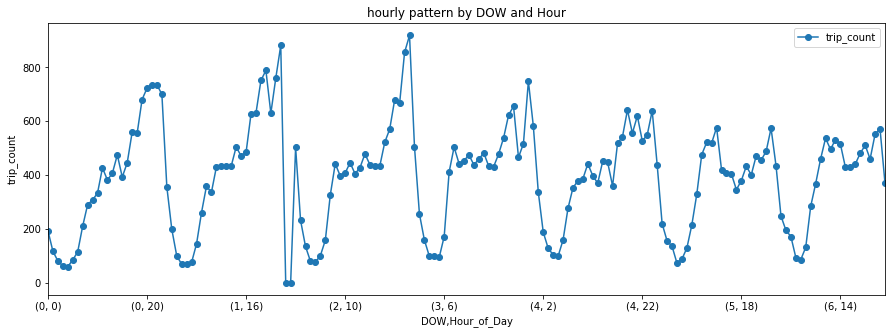

In [85]:
# First Week 12/3 - 12/9 visualize Monday to Sunday
dailyvisual(3,9)

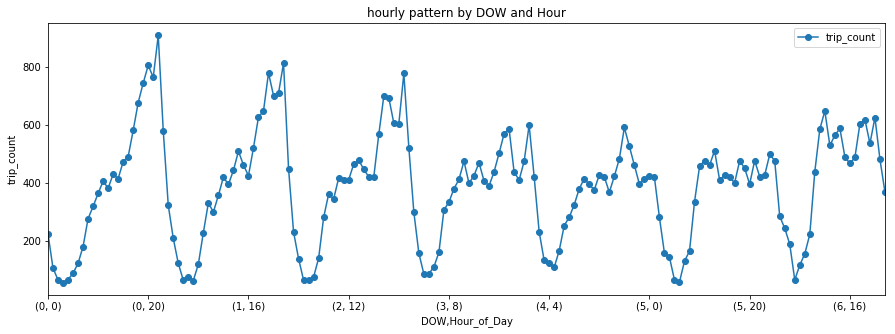

In [86]:
# 12/10 - 12/16
dailyvisual(10,16)

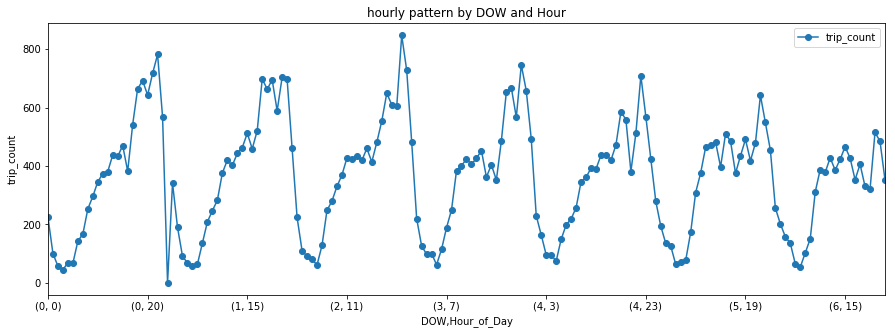

In [87]:
#12/17-12/23
dailyvisual(17,23)

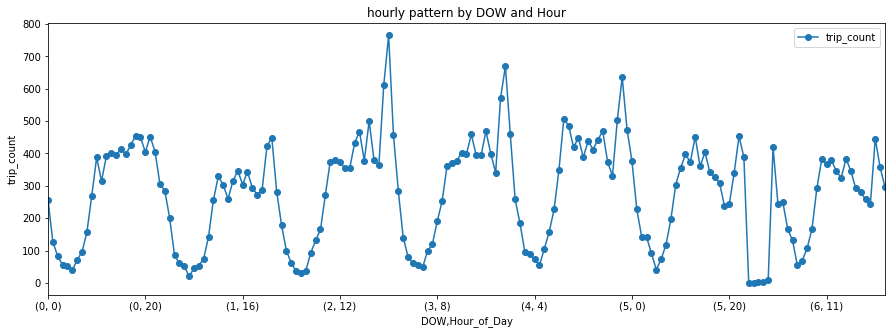

In [88]:
#12/24-12/30
dailyvisual(24,30)